# BVEP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from loss_cal.tasks.bvep import BVEP
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.costs import StepCost_weighted
from loss_cal.bam import train, build_nn
from functools import partial


plot_config_file = "loss_cal/utils/.matplotlibrc"
color_npe = '#377eb8'
color_nn = '#ff7f00'
color_post = '#4daf4a'

task_name="bvep"
action_type="discrete"
seed = seed = 0 #457 #85403

## Set Up

In [3]:
bvep = BVEP(action_type=action_type, num_actions=2, simulator="2D")
bvep.task_name

/Users/mgorecki/Documents/projects/loss-calibration/code/loss-cal/loss_cal/tasks/bvep.py:195: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Epileptor2Dmodel = numba.jit(Epileptor2Dmodel, nopython=False)


'bvep'

Prior and Simulator

In [4]:
prior = bvep.get_prior()
simulator = bvep.get_simulator()

In [5]:
bvep.prior_params

{'low': tensor([-5.0000,  0.1000, -5.0000,  0.0000]),
 'high': tensor([ 0., 50.,  0.,  5.])}

In [6]:
# import numpy as np
# simulator(np.array([-2., 2800.])).shape

## Decision Task

In [7]:
param = 0
eta_crit = -2.05
costs = [5.0, 1.0]
cost_fn = StepCost_weighted(costs, threshold=eta_crit)


### Load Data

In [8]:
# bvep.generate_data(ntrain=5, ntest=1, nval=1, show_progress=True, save_data=False)

In [9]:
theta_train = torch.load(f'./data/bvep/Epileptor2D_summstats/bvep/theta_train.pt')[:, param:param+1]
x_train = torch.load(f'./data/bvep/Epileptor2D_summstats/bvep/x_train.pt')
theta_val = torch.load(f'./data/bvep/Epileptor2D_summstats/bvep/theta_val.pt')[:, param:param+1]
x_val = torch.load(f'./data/bvep/Epileptor2D_summstats/bvep/x_val.pt')
print(theta_train.shape, x_train.shape)

torch.Size([100000, 1]) torch.Size([100000, 50])


In [10]:
# theta_train = torch.vstack([torch.load(f'./data/bvep/Epileptor6D/theta_{i}.pt') for i in range(1,6)])[:, param:param+1]
# x_train = torch.vstack([torch.load(f'./data/bvep/Epileptor6D/x_{i}.pt') for i in range(1,6)])
# theta_val = torch.load('./data/bvep/Epileptor6D/theta_0.pt')[:, param:param+1]
# x_val = torch.load('./data/bvep/Epileptor6D/x_0.pt')
# print(theta_train.shape, x_train.shape)

Remove invalid observations

In [11]:
mask_train = torch.any(x_train.isnan(), dim=1) #NaN and inf
x_train = x_train[~mask_train]
theta_train = theta_train[~mask_train]

mask_val = torch.any(x_val.isnan(), dim=1)
x_val = x_val[~mask_val]
theta_val = theta_val[~mask_val]

print("train:", theta_train.shape, x_train.shape)
print("val", theta_val.shape, x_val.shape)

train: torch.Size([100000, 1]) torch.Size([100000, 50])
val torch.Size([10000, 1]) torch.Size([10000, 50])


In [12]:
x_train.isinf().any(), x_train.isnan().any()

(tensor(False), tensor(False))

Test cost fn

In [13]:
n_train = 10000
theta_train = theta_train[:n_train]
x_train = x_train[:n_train]

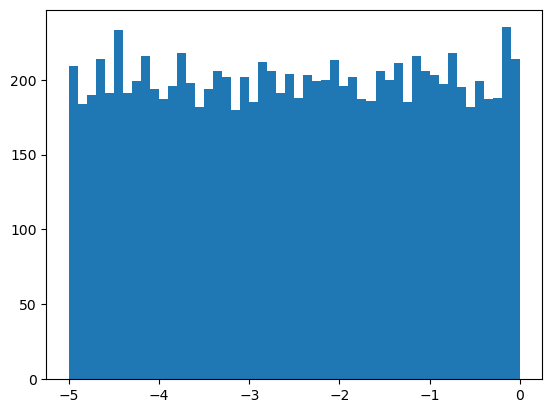

In [14]:
plt.hist(theta_train.numpy(), bins=50)
plt.show()

In [15]:
actions_evaluate = bvep.actions.sample(x_train.shape[0]).float()

### Train NN

In [16]:
def rescaled_cost_fn(true_theta, action, theta_train,  actions_evaluate):
    return (cost_fn(true_theta=true_theta, action=action) - cost_fn(theta_train, actions_evaluate).mean()) / cost_fn(theta_train, actions_evaluate).std()
#partial(rescaled_cost_fn, theta_train=theta_train, actions_evaluate=actions_evaluate)

In [17]:
nn = build_nn(
    model="fc",
    x_train=x_train,
    action_train=actions_evaluate,
    hidden_dims=[100, 100, 100],
    output_dim=1,
    activation=torch.nn.Sigmoid(),
    output_transform=torch.nn.Softplus(),
    seed=seed,
)
print(nn, end="\n-----\n")

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=51, out_features=100, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=100, out_features=100, bias=True)
  )
  (final_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation): Sigmoid()
  (output_transform): Softplus(beta=1, threshold=20)
)
-----


In [18]:
nn, train_loss, val_loss = train(
    model=nn,
    x_train=x_train,
    theta_train=theta_train,
    cost_fn=cost_fn, #partial(rescaled_cost_fn, theta_train=theta_train, actions_evaluate=actions_evaluate),
    x_val=x_val,
    theta_val=theta_val,
    actions=bvep.actions,
    learning_rate=1e-3,
    model_dir=f"./results/{task_name}/discrete/notebook",
    stop_after_epochs=50,
    ckp_interval = 1,
    seed = seed
)

Subdirectory 'checkpoints' already exists. Delete first if wanted.
98	 val_loss = 0.13250080	 train_loss = 0.10627975	 last_improvement = 50
---------------------------------------------------------------------------------
|	Converged after 98 epochs, best achieved validation loss: 0.1272.	|
---------------------------------------------------------------------------------



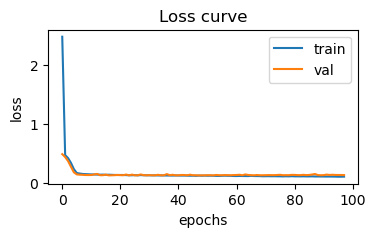

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(train_loss, label="train")
ax.plot(val_loss, label="val")
ax.set_title("Loss curve")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend()
plt.show()

### Evaluate model

In [20]:
predictions_train = nn(x_train, actions_evaluate).detach()
#true_expected_costs_train = torch.Tensor([bvep.expected_posterior_costs(x_o, a, cost_fn=cost_fn, param=) for x_o, a in zip(x_train, actions_evaluate)]) 

(array([4.757e+03, 5.000e+01, 4.000e+01, 3.500e+01, 3.200e+01, 3.100e+01,
        2.800e+01, 3.700e+01, 5.700e+01, 4.230e+02, 2.381e+03, 7.000e+00,
        3.000e+00, 1.000e+00, 3.000e+00, 6.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 5.000e+00, 2.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 4.000e+00,
        6.000e+00, 2.000e+00, 6.000e+00, 5.000e+00, 4.000e+00, 8.000e+00,
        2.000e+00, 3.000e+00, 8.000e+00, 9.000e+00, 4.000e+00, 7.000e+00,
        6.000e+00, 1.000e+01, 1.000e+01, 1.200e+01, 1.100e+01, 1.800e+01,
        3.400e+01, 1.909e+03]),
 array([0.00606303, 0.10618943, 0.20631583, 0.30644223, 0.40656862,
        0.50669503, 0.60682142, 0.7069478 , 0.80707425, 0.90720063,
        1.00732696, 1.10745347, 1.20757985, 1.30770624, 1.40783262,
        1.50795901, 1.60808539, 1.70821178, 1.80833817, 1.90846467,
        2.00859094, 2.10871744, 2.20884371, 2.30897021, 2.40909672,
        2.50922298, 2.60934949, 2.70

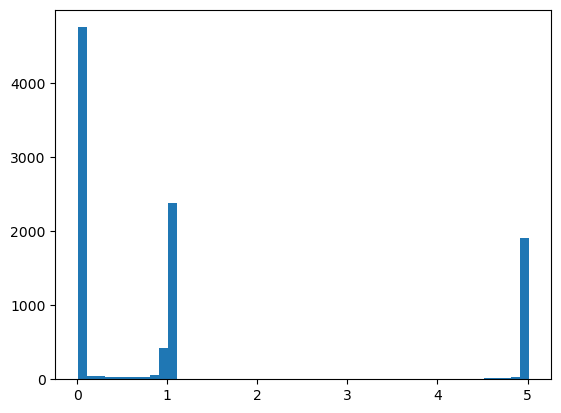

In [21]:
plt.hist(predictions_train.detach().numpy(), bins=50)

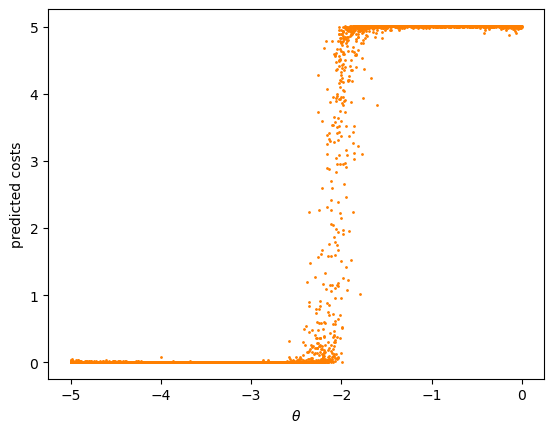

In [22]:
a = 0
cond = (actions_evaluate == a).squeeze()
# plt.scatter(theta_train[cond].numpy().squeeze(), true_expected_costs_train[cond.T], s=1, c=color_post)
plt.scatter(theta_train[cond].numpy().squeeze(), predictions_train[cond].numpy().squeeze(), s=1, c=color_nn)
plt.xlabel(r"$\theta$")
plt.ylabel("predicted costs")
plt.show()